# Recommendations for Potential Folk/Country Artists to Achieve Top Ratings on Pitchfork

Our statistical analysis is centered on the question, what can a potential folk/country artist do to achive top ratings and get best new music on Pitchfork? To answer this question, we did some exploratory data analysis and conducted the the following hypotheses. 
* Is there a statistical difference between the scores of folk/country and metal genres?
* * If so, is folk/country music higher?
* Is there a difference between the scores of folk/country and all other music?
* Is there a difference between the labels the produce a higher percentage of best new music? 
* * And if so, which labels are better?
* What authors that review folk/country music give, on average, higher scores than the average review score? 
* What labels of folk/country music have, on average, review scores greater than the average review score?


Below is the entity relationship diagram for our database.

## Setting Up Database and Importing Libraries

In [1]:
import pandas as pd
import sys
import numpy as np
import sklearn as sk
import psycopg2
import pandas.io.sql as psql
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import mstats
from scipy.stats import ttest_ind
from scipy.stats import ttest_1samp
from statsmodels.stats.power import TTestIndPower

%matplotlib inline

In [2]:
# Create a connection to the database
conn = psycopg2.connect("dbname=pitchfork")

In [3]:
cur = conn.cursor()

## Exploratory Data Analysis

To orient, conduct exploratory queries. Look at table names, columns, and visualize in dataframes.

In [4]:
query_tables_and_columns = """ SELECT table_name, column_name
FROM information_schema.columns
WHERE table_schema= 'public'
ORDER BY table_name, column_name;"""

In [5]:
cur.execute(query_tables_and_columns)

In [6]:
cur.fetchall()

[('artists', 'artist'),
 ('artists', 'id'),
 ('artists', 'reviewid'),
 ('content', 'content'),
 ('content', 'id'),
 ('content', 'reviewid'),
 ('genres', 'genre'),
 ('genres', 'id'),
 ('genres', 'reviewid'),
 ('labels', 'id'),
 ('labels', 'label'),
 ('labels', 'reviewid'),
 ('reviews', 'artist'),
 ('reviews', 'author'),
 ('reviews', 'author_type'),
 ('reviews', 'best_new_music'),
 ('reviews', 'id'),
 ('reviews', 'pub_date'),
 ('reviews', 'pub_day'),
 ('reviews', 'pub_month'),
 ('reviews', 'pub_weekday'),
 ('reviews', 'pub_year'),
 ('reviews', 'reviewid'),
 ('reviews', 'score'),
 ('reviews', 'title'),
 ('reviews', 'url'),
 ('years', 'id'),
 ('years', 'reviewid'),
 ('years', 'year')]

In [7]:
# Create artists dataframe
df_artists = psql.read_sql("SELECT * FROM artists;", conn)
df_artists.head()

,reviewid,artist,id
0,22703,massive attack,1
1,22721,krallice,2
2,22659,uranium club,3
3,22661,kleenex,4
4,22661,liliput,5


In [8]:
# Create content dataframe
df_content = psql.read_sql("SELECT * FROM content;", conn)
df_content.head()

,reviewid,content,id
0,22703,"“Trip-hop” eventually became a ’90s punchline,...",1
1,22721,"Eight years, five albums, and two EPs in, the ...",2
2,22659,Minneapolis’ Uranium Club seem to revel in bei...,3
3,22661,Kleenex began with a crash. It transpired one ...,4
4,22725,It is impossible to consider a given release b...,5


In [9]:
# Create genres dataframe
df_genres = psql.read_sql("SELECT * FROM genres;", conn)
df_genres.head()

,reviewid,genre,id
0,22703,electronic,1
1,22721,metal,2
2,22659,rock,3
3,22661,rock,4
4,22725,electronic,5


In [10]:
df_genres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22680 entries, 0 to 22679
Data columns (total 3 columns):
reviewid    22680 non-null object
genre       20313 non-null object
id          22680 non-null int64
dtypes: int64(1), object(2)
memory usage: 531.6+ KB


There are ~2000 entries with no genre listed, or music that is perhaps, 'genre-defying.' Choose to assume the latter and convert nulls to no_genre. 

In [11]:
df_genres['genre'].fillna('no_genre', inplace=True)

In [12]:
# Create labels dataframe
df_labels = psql.read_sql("SELECT * FROM labels;", conn)
df_labels.head()

,reviewid,label,id
0,22703,virgin,1
1,22721,hathenter,2
2,22659,static shock,3
3,22659,fashionable idiots,4
4,22661,kill rock stars,5


In [13]:
# Create reviews dataframe
df_reviews = psql.read_sql("SELECT * FROM reviews;", conn)
df_reviews.head()

,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,id
0,22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017,1
1,22721,prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,7.9,0,zoe camp,contributor,2017-01-07,5,7,1,2017,2
2,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017,3
3,22661,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017,4
4,22725,new start,taso,http://pitchfork.com/reviews/albums/22725-new-...,8.1,0,kevin lozano,tracks coordinator,2017-01-06,4,6,1,2017,5


In [14]:
# Create years dataframe
df_years = psql.read_sql("SELECT * FROM years", conn)
df_years.head()

,reviewid,year,id
0,22703,1998.0,1
1,22721,2016.0,2
2,22659,2016.0,3
3,22661,2016.0,4
4,22725,2016.0,5


In [15]:
# dataframe of genres and scores
cur.execute("""SELECT score, genre FROM reviews 
            JOIN genres 
            ON reviews.reviewid = genres.reviewid
            ;""")
df_genre_scores = pd.DataFrame(cur.fetchall())
df_genre_scores.columns = [i[0] for i in cur.description]

Change null values to 'no_genre'.

In [16]:
df_genre_scores['genre'].fillna('no_genre', inplace=True)

In [17]:
df_genre_scores.head()

,score,genre
0,9.3,electronic
1,7.9,metal
2,7.3,rock
3,9.0,rock
4,8.1,electronic


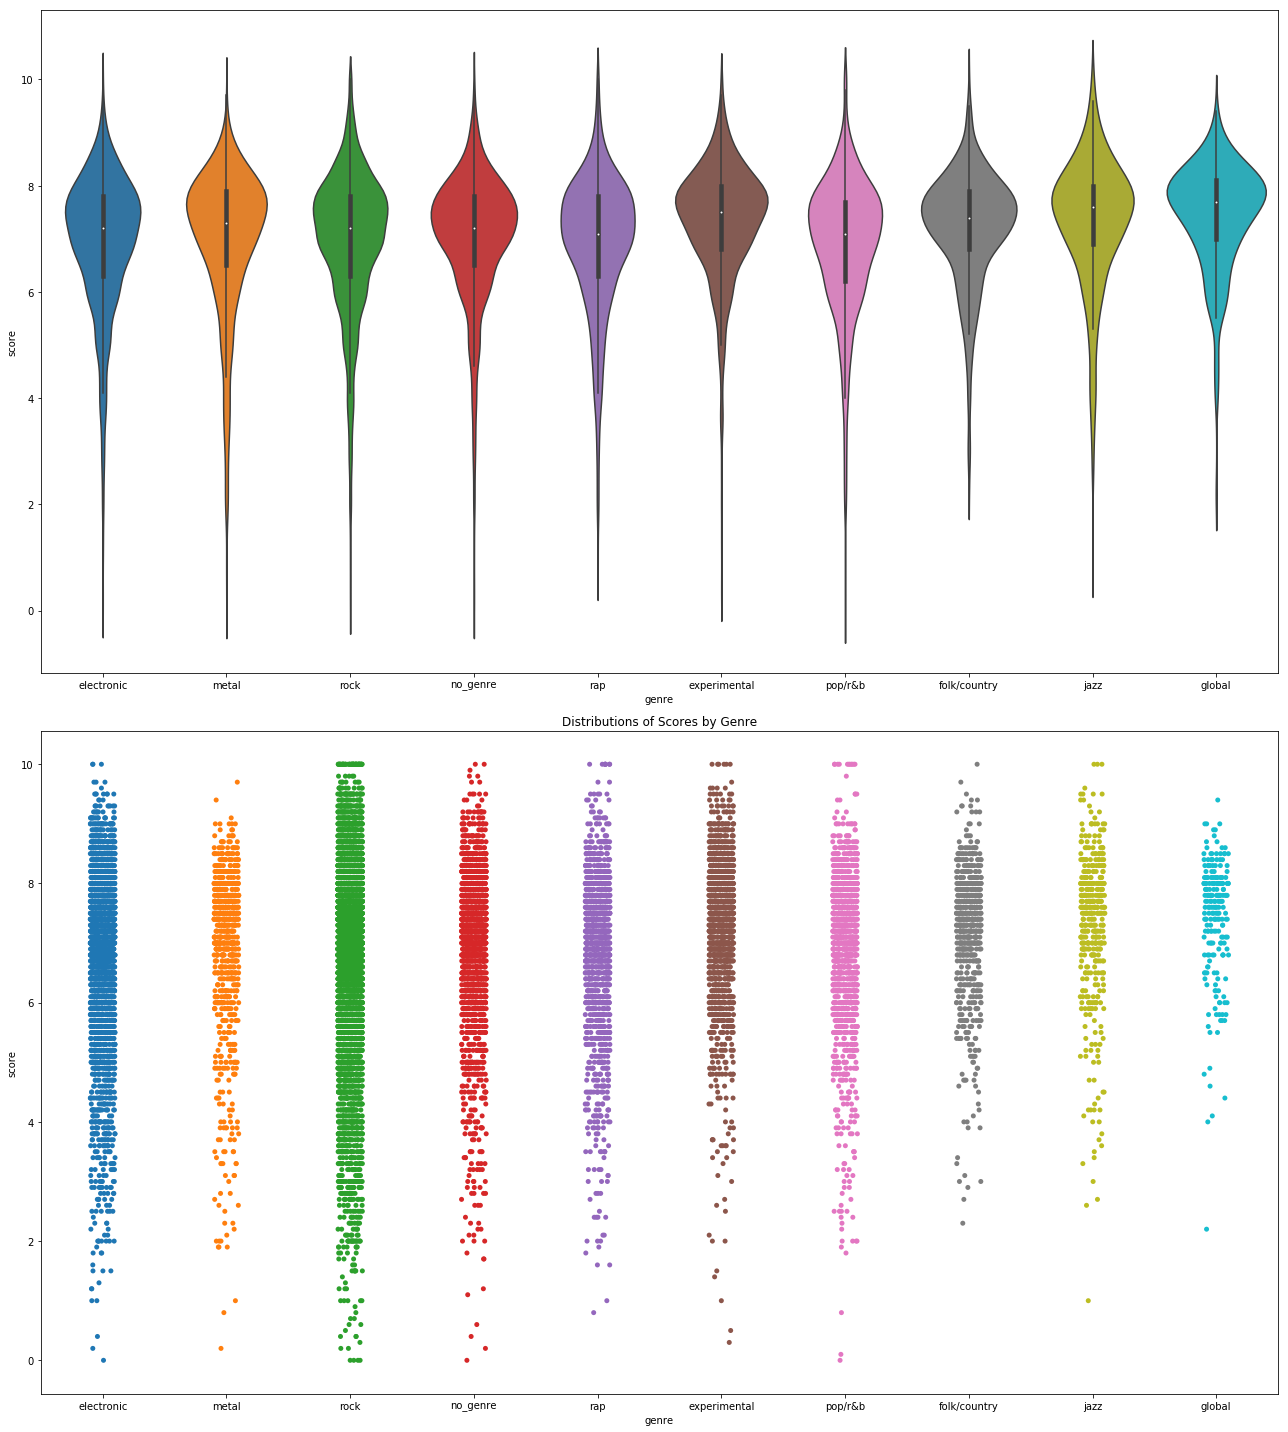

In [18]:
# Visualize distributions of scores by genre

f, axes = plt.subplots(2, 1, figsize = (18, 20))
plt.title("Distributions of Scores by Genre")
sns.violinplot(x="genre", y="score", data=df_genre_scores, ax = axes[0])
sns.stripplot(x="genre", y="score", data=df_genre_scores, ax = axes[1])
plt.tight_layout()

Notice that the mean values and kernel densities look similar across the genres.

## Question 1: Is there a statistical difference between the scores of folk/country and metal genres?

Null hypothesis: There is no difference between the mean score of folk/country and metal genres. <br>
Alternative Hypothesis: There is a difference between the mean score of folk/country and metal genres.

In [19]:
# Create dataframe for folk/country and scores
is_folk = df_genre_scores['genre']== 'folk/country'
folk_scores = df_genre_scores.loc[is_folk]
folk_scores.head()

,score,genre
28,6.8,folk/country
78,7.8,folk/country
127,7.3,folk/country
147,8.5,folk/country
152,7.8,folk/country


In [20]:
folk_scores.describe()

,score
count,685.000000
mean,7.202190
std,1.064435
min,2.300000
25%,6.800000
50%,7.400000
75%,7.900000
max,10.000000


In [21]:
# Create dataframe for metal and scores
is_metal = df_genre_scores['genre']== 'metal'
metal_scores = df_genre_scores.loc[is_metal]
metal_scores.head()

,score,genre
1,7.9,metal
22,7.5,metal
33,7.7,metal
124,6.5,metal
146,6.4,metal


In [22]:
metal_scores.describe()

,score
count,862.000000
mean,6.950000
std,1.387799
min,0.200000
25%,6.500000
50%,7.300000
75%,7.900000
max,9.700000


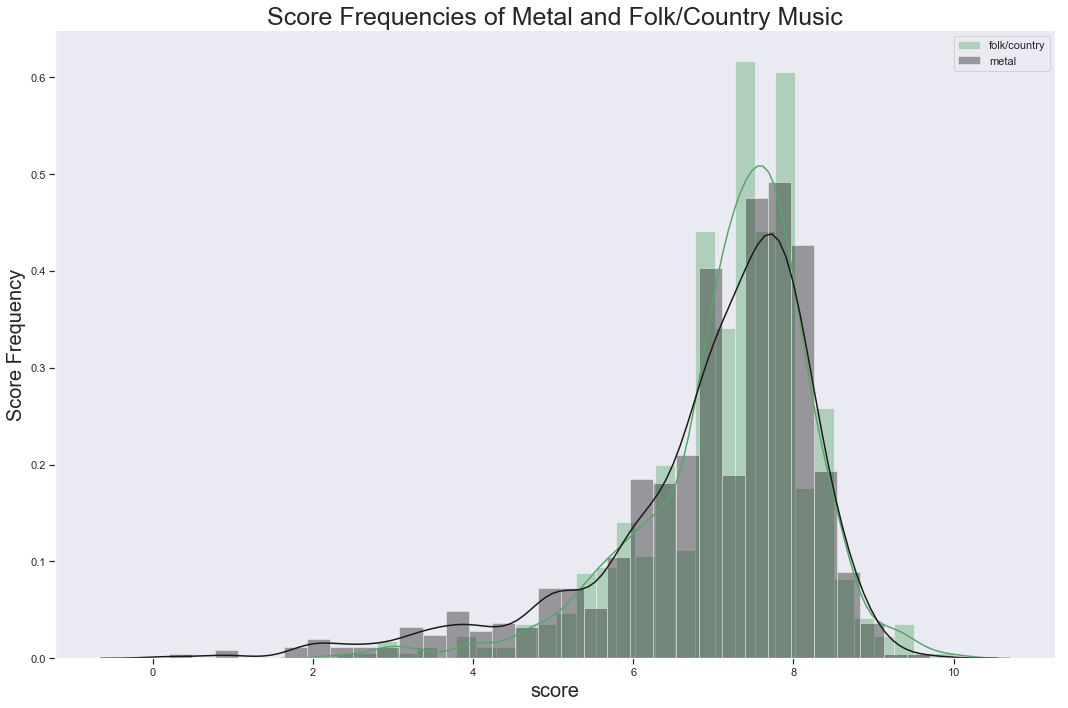

In [23]:
#Look at the distributions of scores for metal and folk/country genres
#futurewarning has to do with sns using scipy.stats for calculations, and will be addressed 
sns.set()
plt.figure(figsize=(15,10))
sns.set_style("dark", {"xtick.bottom":True, "ytick.left":True})
plt.xlabel('Score', fontsize='20')
plt.ylabel('Score Frequency', fontsize='20')
plt.title('Score Frequencies of Metal and Folk/Country Music', fontsize='25')
sns.distplot(folk_scores['score'], color='g', label='folk/country')
sns.distplot(metal_scores['score'], color='k', label='metal')
sns.despine()
plt.tight_layout()
plt.legend()
plt.show();

Test Null Hypothesis. Assume p-value < 0.05 to reject null hypothesis. The standard deviations are different, thus the variances are different, so we'll set "equal_var=False" to use Welch's test.

In [24]:
ttest_ind(folk_scores['score'], metal_scores['score'], axis=0, equal_var=False)

Ttest_indResult(statistic=4.044303101957469, pvalue=5.507059645103283e-05)

The pvalue for this test, 0.0000507, is much smaller than our 0.05, rejecting the null hypothesis.

Now we check that we have enough samples for a large effect and a 95% confidence interval.

In [25]:
# Initialize parameters
effect = 0.8
alpha = 0.05
power = 0.8
# Size of folk/country scores sample to all other music sample
ratio = len(metal_scores) / len(folk_scores)
print(ratio)
# Perform power analysis
analysis = TTestIndPower()
result = analysis.solve_power(effect, power=power, nobs1=None,
                              ratio=ratio, alpha=alpha)
print(f"Minimum Sample Size: {result}")
print(f"Folk/Country Sample Size: {len(folk_scores)}")

1.2583941605839417
Minimum Sample Size: 22.891880051492222
Folk/Country Sample Size: 685


Our sample size is easily large enough. Let's look at how the power size would change given fewer samples:

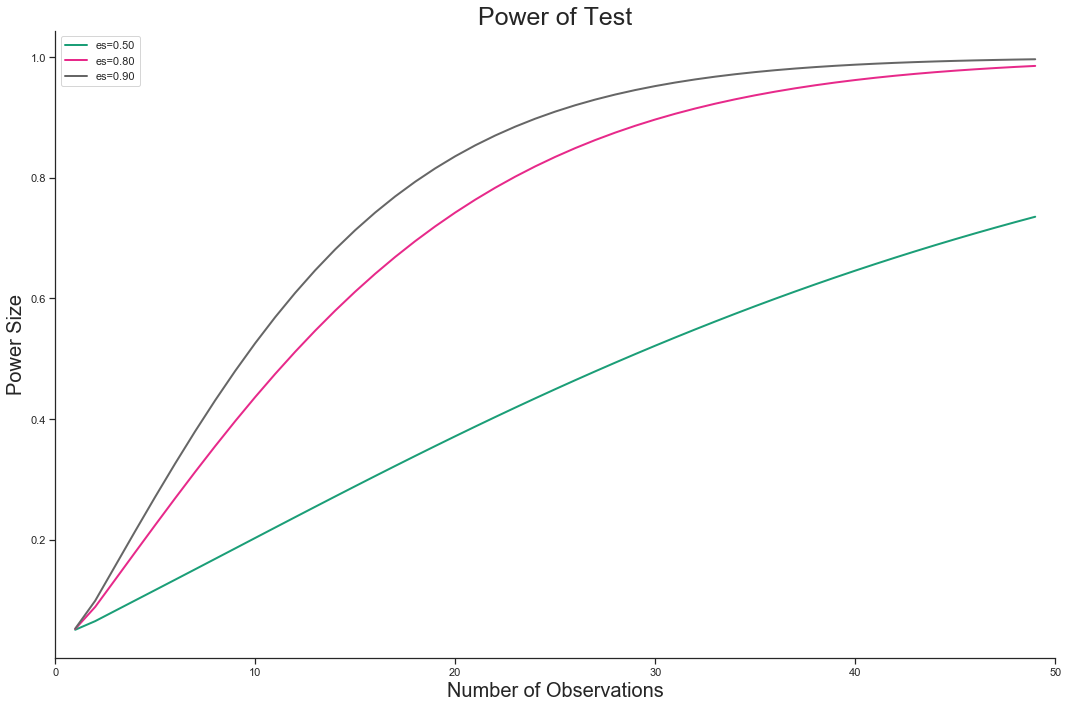

In [26]:
# parameters for power analysis
effect_sizes = np.array([0.5, 0.8, 0.9])
sample_sizes = np.array(range(1, 50))
# Calculate multiple power analysis curves
analysis = TTestIndPower()
sns.set()
sns.set_style("white", {"xtick.bottom":True, "ytick.left":True})
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)
ax = analysis.plot_power(dep_var='nobs', nobs=sample_sizes, ax=ax, ratio=ratio, effect_size=effect_sizes)
plt.xlabel('Number of Observations', fontsize='20')
plt.xlim(0, 50)
plt.ylabel('Power Size', fontsize='20')
plt.title('Power of Test', fontsize='25')
sns.despine()
plt.tight_layout()
plt.legend()
plt.show();

Based on the power analysis, we can accept results of the hypothesis test.

We reject the null hypothesis in favor of the alternative hypothesis. There is a difference between mean scores of folk/country and metal genres.

## Question 1A: Does the folk/country genre receive higher scores than metal?

Null hypothesis: The mean score of folk/country is not larger than the mean score of metal genres. <br>
Alternative Hypothesis: The mean score of folk/country is larger than the mean score of metal genres.

This calls for a one-tailed test with p-value <0.025 to reject the null hypothesis.

In [27]:
ttest_ind(folk_scores['score'], metal_scores['score'], axis=0, equal_var=False)

Ttest_indResult(statistic=4.044303101957469, pvalue=5.507059645103283e-05)

The pvalue for this test, 0.0000507, is much smaller than our 0.05, rejecting the null hypothesis.

We reject the null hypothesis. The mean score of folk/country is larger than the mean score of metal genres.

## Question 2: Is there a difference between the scores of folk/country music and all other music?

Check unique list of genres. Include value counts.

In [28]:
query_unique_genres = """ SELECT genre, COUNT(genres)
FROM genres
GROUP BY genre;"""

In [29]:
cur.execute(query_unique_genres)

In [30]:
cur.fetchall()

[('global', 217),
 ('experimental', 1815),
 ('metal', 860),
 (None, 2367),
 ('electronic', 3874),
 ('folk/country', 685),
 ('pop/r&b', 1432),
 ('jazz', 435),
 ('rap', 1559),
 ('rock', 9436)]

Going with 'folk/country.' Reviews seem to be rated by 'score' and 'best new music.' Look at descriptive statistics and variances. Make distributions of 'folk/country' and all other music. 

In [31]:
og_df = df_genre_scores[df_genre_scores['genre'] != 'folk/country'].copy()

In [32]:
print(og_df.describe())
print(folk_scores.describe())

              score
count  22005.000000
mean       6.984585
std        1.311801
min        0.000000
25%        6.400000
50%        7.200000
75%        7.800000
max       10.000000
            score
count  685.000000
mean     7.202190
std      1.064435
min      2.300000
25%      6.800000
50%      7.400000
75%      7.900000
max     10.000000


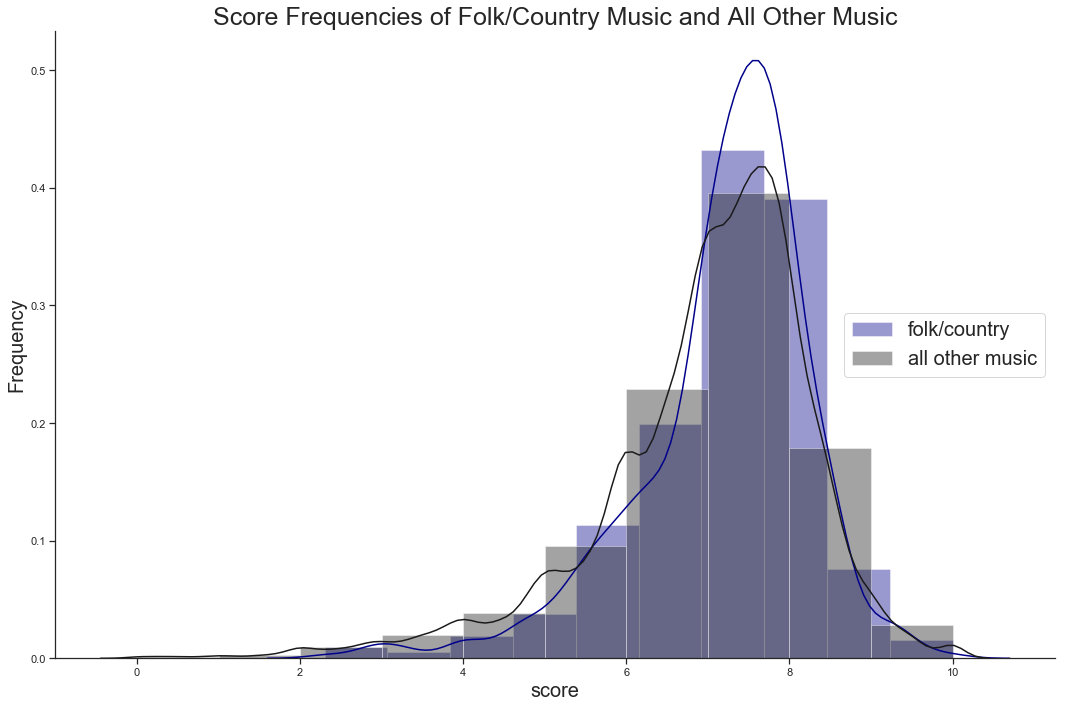

In [33]:
sns.set()
plt.figure(figsize=(15,10))
sns.set_style("white", {"xtick.bottom":True, "ytick.left":True})
plt.xlabel('Score', fontsize='20')
plt.ylabel('Frequency', fontsize='20')
plt.title('Score Frequencies of Folk/Country Music and All Other Music', fontsize='25')
sns.distplot(folk_scores['score'], color='darkblue', bins=10, label='folk/country')
sns.distplot(og_df['score'], color='k', bins=10, label='all other music')
sns.despine()
plt.tight_layout()
plt.legend(loc='center right', fontsize=20)
plt.show();

From a visual, it looks like there is little, if any, difference between the distribution of folk/country ratings and all other music. To determine whether folk/country ratings or all other music ratings we use a Welch's t-test to compare the average ratings for each sample. We also conduct a power analysis. By convention, significance level (alpha) is 0.05, effect size (Cohen's d measure) is at least 0.8, and statistical power is 0.8. Our hypotheses are: <br> <br>
Null Hypothesis: The mean difference between review score for folk/country and all other music is zero. <br>
Alternative Hypothesis: The mean difference between folk/country review score and all other music is different from zero. <br>

In [152]:
n = 50

In [34]:
def bootstrap(data, stat=np.mean, n_bootstraps=10**5):
    """Return bootstrap stat of sample."""
    bootstrap_stats = np.zeros(n_bootstraps)
    n = len(data)
    for i in range(10**5):
        bootstrap_sample = np.random.choice(data, size=n)
        bootstrap_stats[i] = stat(bootstrap_sample)
    return bootstrap_stats

In [153]:
folk_small = np.random.choice(folk_scores['score'], size=n, replace=False)

In [154]:
folk_stats = bootstrap(folk_small)

In [155]:
og_small = np.random.choice(og_df['score'], size=n, replace=False)

In [156]:
og_stats = bootstrap(og_small)

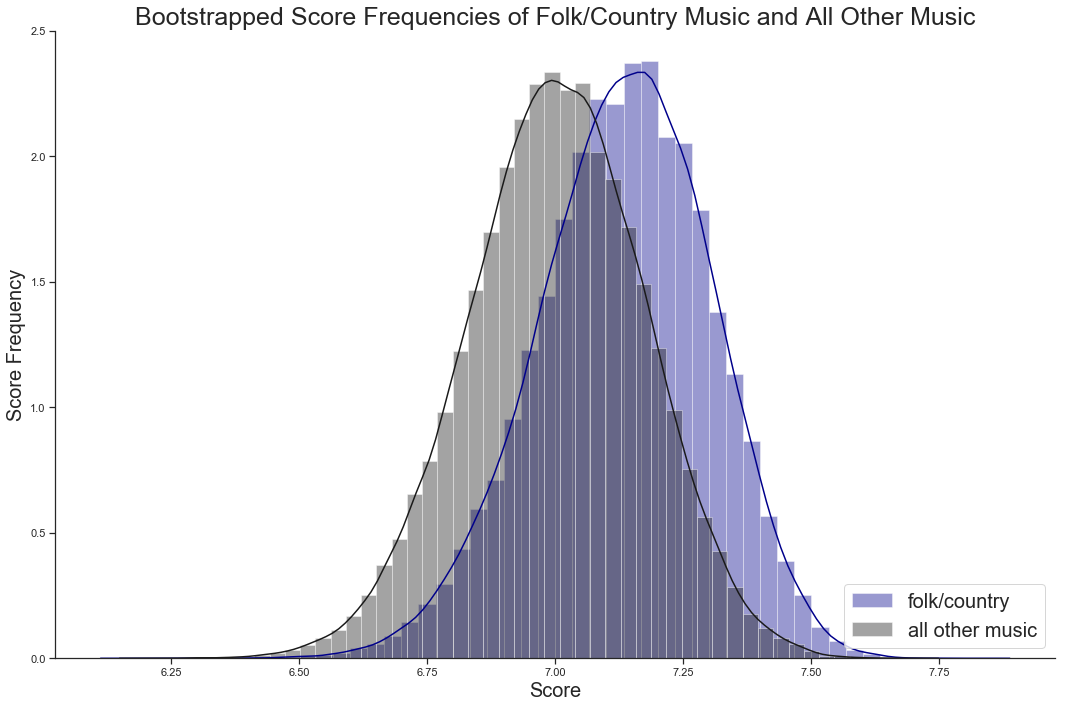

In [157]:
sns.set()
plt.figure(figsize=(15,10))
sns.set_style("white", {"xtick.bottom":True, "ytick.left":True})
plt.xlabel('Score', fontsize='20')
plt.ylabel('Score Frequency', fontsize='20')
plt.title('Bootstrapped Score Frequencies of Folk/Country Music and All Other Music', fontsize='25')
sns.distplot(folk_stats, color='darkblue', label='folk/country')
sns.distplot(og_stats, color='k', label='all other music')
sns.despine()
plt.tight_layout()
plt.legend(loc='lower right', fontsize=20)
plt.show();

In [158]:
# Use scipy.stats to conduct 2-tailed, 2-sample t-test
ttest_ind(folk_small, og_small, equal_var=False)

Ttest_indResult(statistic=0.5432249903210906, pvalue=0.588208720528121)

In [159]:
(folk_stats > og_stats).sum() / 10**5

0.70902

The p-value is significantly less than 0.05. There is enough evidence to reject the null hypothesis and suggest a statistical difference in the average review scores between folk/country and all other music. We do a follow-up one-tailed Welch's t-test to see if the average score for folk/country music is greater than that of all other music. <br> <br>
Null Hypothesis: The mean review score for folk/country music and all other music is the same. <br>
Alternative Hypothesis: The mean review score for folk/country music is greater than the mean review score for all other music.

In [39]:
# Use scipy.stats to conduct above-case, 2-sample t-test
results = ttest_ind(folk_stats, og_stats, equal_var=False)
pvalue = results[1]/2
print(results[0], pvalue)

1656.8393591237555 0.0


To give results context, we do a power analysis to estimate a suitable sample size (how many observations needed for each sample) for an effect size of 0.8 with an 80% chance of detecting the effect if it is true (so 20% false negatives) and a 5% chance of detecting an effect if there is no effect (false positives). 

In [40]:
def p_analysis_unequal_samples(data1, data2, effect, alpha, power):
    """Return minimum sample size for unequal sample size comparison."""
    ratio = len(data1) / len(data2)  
    result = TTestIndPower().solve_power(effect, power=power, nobs1=None,
                             ratio=ratio, alpha=alpha)
    print(f"Minimum Sample Size: {result}")
    print(f"Sample Sizes: {len(data1)}, {len(data2)}")

In [41]:
p_analysis_unequal_samples(folk_scores, og_df, 0.8, .05, 0.8)

Minimum Sample Size: 408.09978349002654
Sample Sizes: 685, 22005


The sample sizes for folk/country music scores and all other music scores are larger than the minimum sample size. There is an 80% chance of detecting larger effect sizes (0.8) at a 0.05 alpha level. 

## Question 3: What labels produce the most best new music? Is there a difference between the labels that produce a higher percentage of best new music? And if so, which labels are better?

First, we identified visually which labels seem to produce more best new music on average. 

In [42]:
# Create a connection to the database
conn = psycopg2.connect("dbname=pitchfork")
cur = conn.cursor()

Let's take a look at the labels with the totals of "Best New Music" produced.

In [43]:
cur.execute('''SELECT label, sum(reviews.best_new_music) AS num_best_new_music, 
            count(label) AS times_reviewed
            FROM reviews
            JOIN labels
            ON reviews.reviewid = labels.reviewid
            GROUP BY label''')
#create dataframe
df_label_counts_best = pd.DataFrame(cur.fetchall())
df_label_counts_best.columns = [i[0] for i in cur.description]

df_label_counts_best = df_label_counts_best.sort_values(by=['num_best_new_music'], ascending=False)
df_label_counts_best.head()

,label,num_best_new_music,times_reviewed
2899,domino,36,211
243,sub pop,32,268
1216,4ad,31,126
3243,matador,23,202
2555,warp,23,217


In [44]:
df_label_counts_best.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3668 entries, 2899 to 3667
Data columns (total 3 columns):
label                 3667 non-null object
num_best_new_music    3668 non-null int64
times_reviewed        3668 non-null int64
dtypes: int64(2), object(1)
memory usage: 114.6+ KB


There are many, many labels. We'll look at the labels which have produced 6 or more "Best New Music" albums.

In [45]:
df_labels_most_best = df_label_counts_best[df_label_counts_best['num_best_new_music'] >= 6].copy()
#convert datatypes for division
df_labels_most_best['num_best_new_music'] = df_labels_most_best['num_best_new_music'].astype(int)
df_labels_most_best['times_reviewed'] = df_labels_most_best['times_reviewed'].astype(int)
df_labels_most_best.head()

,label,num_best_new_music,times_reviewed
2899,domino,36,211
243,sub pop,32,268
1216,4ad,31,126
3243,matador,23,202
2555,warp,23,217


In [46]:
#add column
df_labels_most_best['percent_best'] = 100*df_labels_most_best['num_best_new_music'] / df_labels_most_best['times_reviewed']
df_labels_most_best = df_labels_most_best.sort_values(by=['percent_best'], ascending=False)
df_labels_most_best.head()

,label,num_best_new_music,times_reviewed,percent_best
685,roc-a-fella,8,20,40.000000
1216,4ad,31,126,24.603175
288,modular,6,26,23.076923
3031,true panther,7,31,22.580645
1202,legacy,12,54,22.222222


In [47]:
df_labels_most_best.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47 entries, 685 to 3428
Data columns (total 4 columns):
label                 47 non-null object
num_best_new_music    47 non-null int64
times_reviewed        47 non-null int64
percent_best          47 non-null float64
dtypes: float64(1), int64(2), object(1)
memory usage: 1.8+ KB


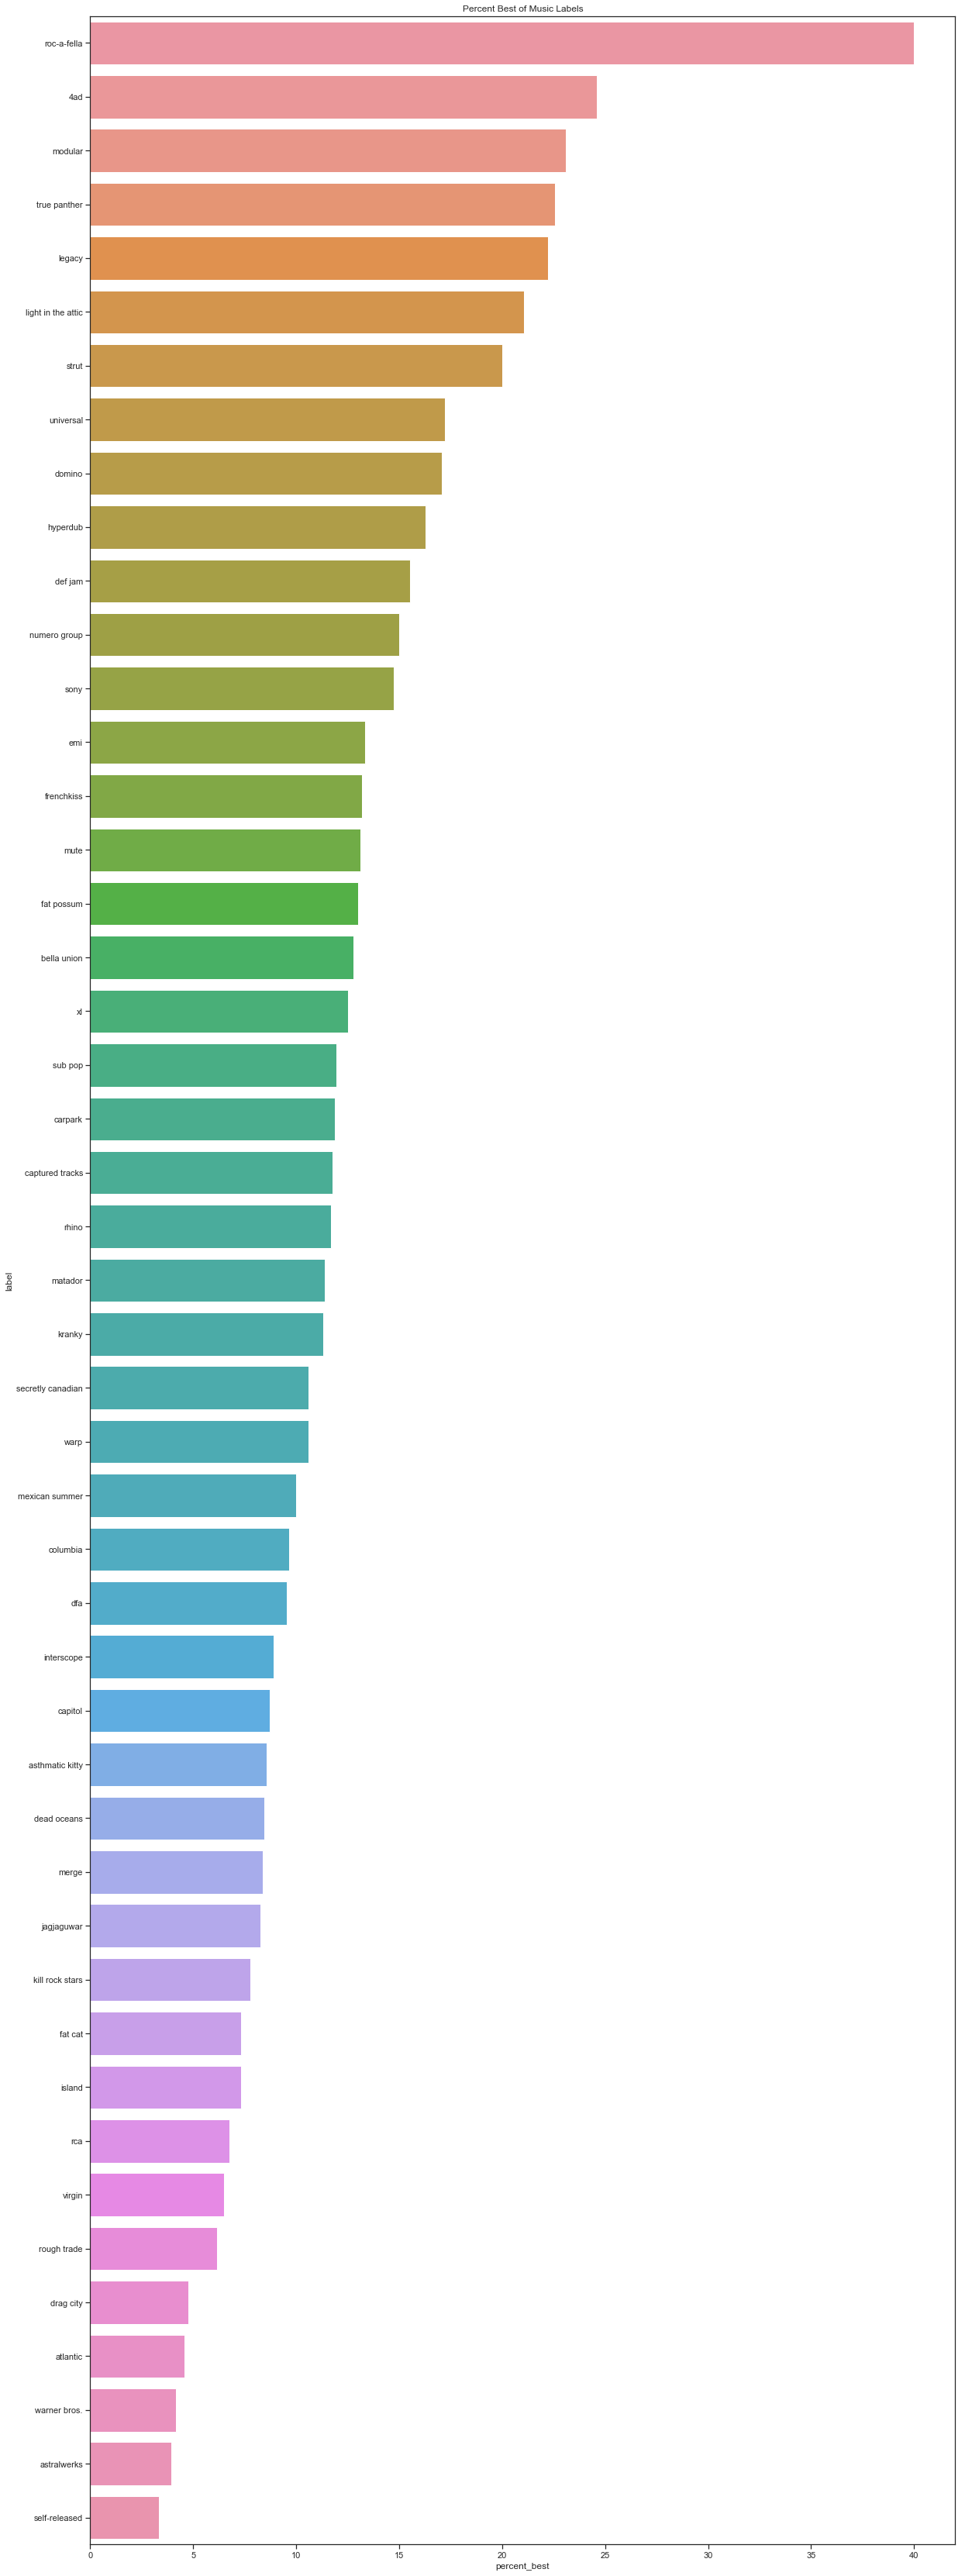

In [48]:
#look at distributions
f, x = plt.subplots(figsize=(20,60))
sns.barplot(x='percent_best', y='label', data=df_labels_most_best)
plt.title('Percent Best of Music Labels');

How accurate does this look?

Of these, which produce folk/country albums?

In [49]:
# Create a connection to the database
conn = psycopg2.connect("dbname=pitchfork")
cur = conn.cursor()

In [50]:
#What genres does each label produce?
query = '''SELECT label, STRING_AGG(genres.genre, ',') AS all_genres
            from labels
            join genres
            ON labels.reviewid = genres.reviewid
            GROUP BY label
            ;'''

In [51]:
#What genres does each label produce?
cur.execute(query)
df_label_genres = pd.DataFrame(cur.fetchall())
df_label_genres.columns = [i[0] for i in cur.description]
df_label_genres.head(n=20)

,label,all_genres
0,,"rock,electronic,rock,electronic,metal,rock,jaz..."
1,deux,rock
2,!k7,"rock,electronic,electronic,electronic,electron..."
3,+1,"rock,electronic,rock,rock"
4,00:02:59,folk/country
5,1-2-3-4 go!,"rock,rock"
6,1-800 dinosaur,rap
7,10 summers,rap
8,100%,"electronic,rock"
9,100% silk,"electronic,experimental,rock,electronic"


In [52]:
# Create a connection to the database
conn = psycopg2.connect("dbname=pitchfork")
cur = conn.cursor()

In [53]:
#Which labels have produced best new music and produce folk albums?
query = """
SELECT 
   sum(best_new_music) AS num_best_new_music
  , label 
  , STRING_AGG(genres.genre, ',') AS all_genres 
FROM reviews 
JOIN genres
ON reviews.reviewid = genres.reviewid
JOIN labels
ON reviews.reviewid = labels.reviewid
GROUP BY label
HAVING SUM(best_new_music) > 0
AND STRING_AGG(genres.genre, ',') LIKE '%folk/country%'
;"""

In [54]:
#Which labels have produced best new music and produce folk albums?
cur.execute(query)
df_label_most_awards_folk = pd.DataFrame(cur.fetchall())
df_label_most_awards_folk.columns = [i[0] for i in cur.description]
df_label_most_awards_folk = df_label_most_awards_folk.sort_values(by=['num_best_new_music'],
                             ascending=False)
df_label_most_awards_folk.head()

,num_best_new_music,label,all_genres
30,45,domino,"electronic,rock,rock,rock,rock,rock,rock,exper..."
86,36,sub pop,"rock,rock,rock,rock,electronic,rock,rock,pop/r..."
1,35,4ad,"rock,rock,folk/country,pop/r&b,rap,electronic,..."
67,33,mute,"electronic,experimental,rock,rock,electronic,r..."
61,26,matador,"rock,rock,electronic,rock,metal,rock,rock,rock..."


In [55]:
df_label_most_awards_folk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101 entries, 30 to 50
Data columns (total 3 columns):
num_best_new_music    101 non-null int64
label                 100 non-null object
all_genres            101 non-null object
dtypes: int64(1), object(2)
memory usage: 3.2+ KB


In [56]:
# Create a connection to the database
conn = psycopg2.connect("dbname=pitchfork")
cur = conn.cursor()

In [57]:
#What are the labels with all genres, total best new musics, and times reviewed per label?
query = """
SELECT 
  label 
  , sum(best_new_music) AS num_best_new_music
  , count(*) AS times_reviewed
  , STRING_AGG(genres.genre, ' , ') AS all_genres 
FROM reviews 
JOIN labels 
ON reviews.reviewid = labels.reviewid
JOIN genres
ON reviews.reviewid = genres.reviewid
GROUP BY label
;"""

In [58]:
#What are the labels with all genres, total best new musics, and times reviewed per label?
cur.execute(query)
df_labels_genres_most_awards = pd.DataFrame(cur.fetchall())
df_labels_genres_most_awards.columns = [i[0] for i in cur.description]
df_labels_genres_most_awards = df_labels_genres_most_awards.sort_values(by=['num_best_new_music'], 
                                                                        ascending=False)
df_labels_genres_most_awards.head()

,label,num_best_new_music,times_reviewed,all_genres
922,domino,45,284,"electronic , rock , rock , rock , rock , rock ..."
3096,sub pop,36,337,"rock , rock , rock , rock , electronic , rock ..."
47,4ad,35,139,"rock , rock , folk/country , pop/r&b , rap , e..."
2175,mute,33,240,"electronic , experimental , rock , rock , elec..."
2001,matador,26,231,"rock , rock , electronic , rock , metal , rock..."


In [59]:
df_folk_labels_most_best = df_labels_genres_most_awards[df_labels_genres_most_awards['num_best_new_music'] >= 6].copy()
#convert datatypes for division
df_folk_labels_most_best['num_best_new_music'] = df_labels_most_best['num_best_new_music'].astype(int)
df_folk_labels_most_best['times_reviewed'] = df_labels_most_best['times_reviewed'].astype(int)
df_folk_labels_most_best.head()
#

,label,num_best_new_music,times_reviewed,all_genres
922,domino,NaN,NaN,"electronic , rock , rock , rock , rock , rock ..."
3096,sub pop,NaN,NaN,"rock , rock , rock , rock , electronic , rock ..."
47,4ad,NaN,NaN,"rock , rock , folk/country , pop/r&b , rap , e..."
2175,mute,NaN,NaN,"electronic , experimental , rock , rock , elec..."
2001,matador,NaN,NaN,"rock , rock , electronic , rock , metal , rock..."


In [60]:
#Which what are the total bests and reviews of labels that produced 
# best new music and folk albums?
query = """
SELECT 
  label 
  , sum(best_new_music) AS num_best_new_music
  , count(*) AS times_reviewed
FROM reviews 
JOIN genres
ON reviews.reviewid = genres.reviewid
JOIN labels
ON reviews.reviewid = labels.reviewid
GROUP BY label
HAVING SUM(best_new_music) > 0
AND STRING_AGG(genres.genre, ',') LIKE '%folk/country%'
;"""

In [61]:
#Which what are the total bests and reviews of labels that produced 
# best new music and folk albums?
cur.execute(query)

df_folk_labels_most_best = pd.DataFrame(cur.fetchall())
df_folk_labels_most_best.columns = [i[0] for i in cur.description]
df_folk_labels_most_best = df_folk_labels_most_best.sort_values(by=['num_best_new_music'], 
                                                                        ascending=False)
df_folk_labels_most_best.head()

,label,num_best_new_music,times_reviewed
30,domino,45,284
86,sub pop,36,337
1,4ad,35,139
67,mute,33,240
61,matador,26,231


In [62]:
df_folk_labels_most_best.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101 entries, 30 to 50
Data columns (total 3 columns):
label                 100 non-null object
num_best_new_music    101 non-null int64
times_reviewed        101 non-null int64
dtypes: int64(2), object(1)
memory usage: 3.2+ KB


In [63]:
#Select for labels which produced 6 or more best_new_music, 
#prepare data for division, and add percentage column.
df_folk_labels_most_best = df_folk_labels_most_best[df_folk_labels_most_best['num_best_new_music'] >= 6].copy()
df_folk_labels_most_best['times_reviewed'] = df_folk_labels_most_best['times_reviewed'].astype(int)
#add column
df_folk_labels_most_best['percent_best'] = 100*df_folk_labels_most_best['num_best_new_music'] / df_folk_labels_most_best['times_reviewed'] 
df_folk_labels_most_best = df_folk_labels_most_best.sort_values(by=['percent_best'], ascending=False)
df_folk_labels_most_best.head()


,label,num_best_new_music,times_reviewed,percent_best
1,4ad,35,139,25.179856
60,light in the attic,13,61,21.311475
59,legacy,12,57,21.052632
30,domino,45,284,15.845070
69,numero group,9,62,14.516129


In [64]:
df_folk_labels_most_best.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35 entries, 1 to 94
Data columns (total 4 columns):
label                 35 non-null object
num_best_new_music    35 non-null int64
times_reviewed        35 non-null int64
percent_best          35 non-null float64
dtypes: float64(1), int64(2), object(1)
memory usage: 1.4+ KB


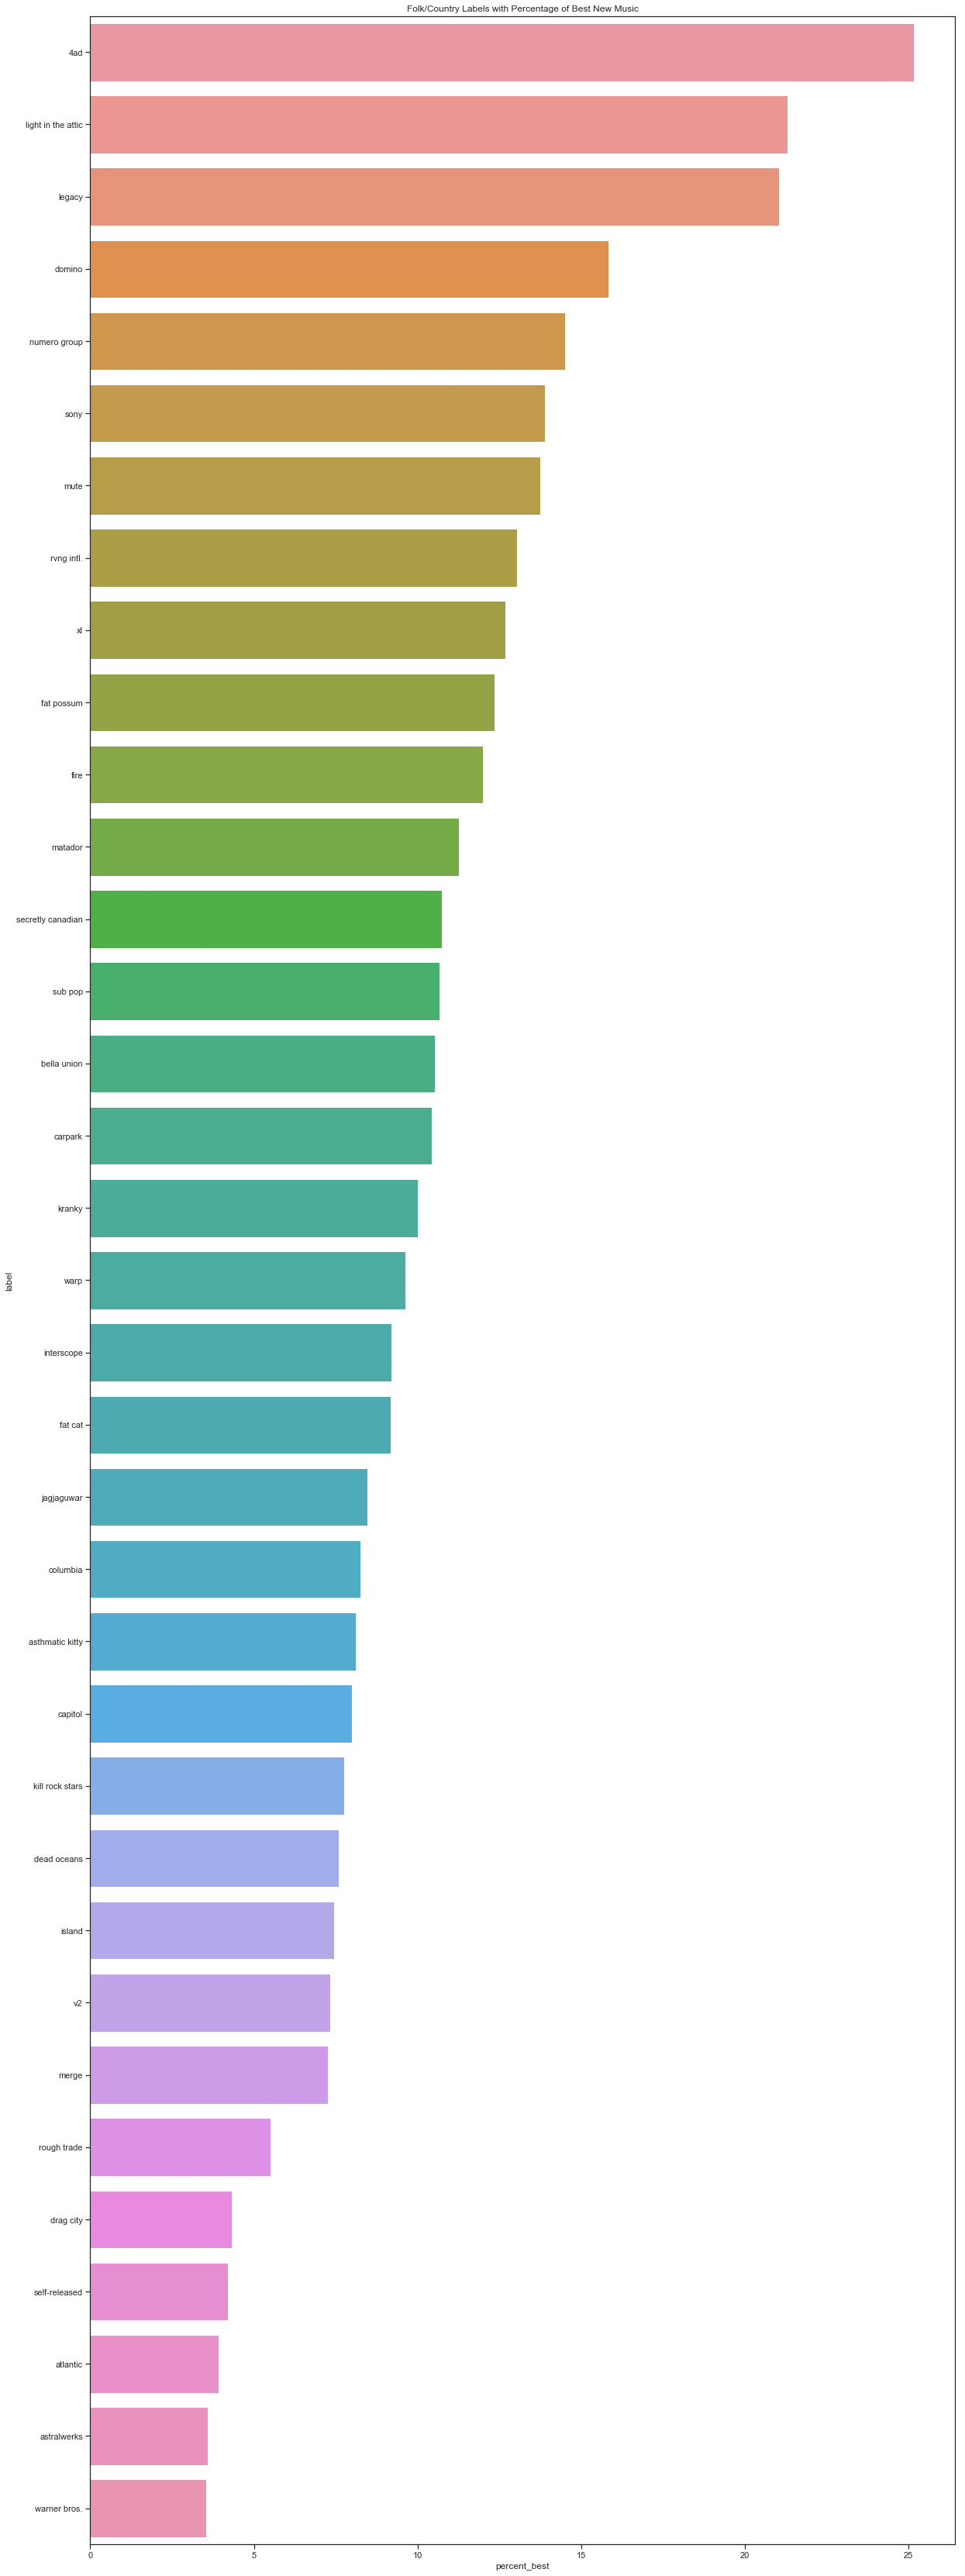

In [65]:
#look at distributions
f, x = plt.subplots(figsize=(20,60))
sns.barplot(x='percent_best', y='label', data=df_folk_labels_most_best)
plt.title('Folk/Country Labels with Percentage of Best New Music');

It sure looks like roc-a-fella has the highest percentage of best_new_music of all labels, while 4ad has the highest percentage of all the labels that produce folk. But how generalizable is this? We'll compare roc-a-fella with the second highest percentage of all labels (in this case 4ad). Then we'll compare 4ad (the highest percentage of folk) with second highest percentage of folk labels, Light in the Attic. We compared the top five labels across genres in pairs - comparing the one with the highest percentage to the second highest, the second highest to the third highest, etc. Of those top five, three produce folk/country music, so we did pair comparisons of those three to each other with only folk/country best new music awards. We decide to bootstrap the samples to minimize random chance affecting our samples. 

In [66]:
df_labels_most_best.head(6)

,label,num_best_new_music,times_reviewed,percent_best
685,roc-a-fella,8,20,40.000000
1216,4ad,31,126,24.603175
288,modular,6,26,23.076923
3031,true panther,7,31,22.580645
1202,legacy,12,54,22.222222
2563,light in the attic,12,57,21.052632


In [67]:
def bootstrapper(data):
    """Return array of sample means from bootstrapping n_samples times."""
    output = np.zeros(10**6)
    n = len(data)
    for i in range(10**6):
        bootstrap_sample = np.random.choice(data, 
                                            size=n,
                                            replace=True)
        output[i] = (bootstrap_sample.sum() / n)
    return output

In [68]:
roc_a_fella = np.array([0] * 12 + [1] * 8)
four_ad = np.array([0] * 95 + [1] * 31)
modular = np.array([0] * 20 + [1] * 26)
true_panther = np.array([0] * 24 + [1] * 31)
legacy = np.array([0] * 42 + [1] * 54)
light_attic = np.array([0] * 48 + [1] * 31)

In [69]:
roc_a_fella_dist = bootstrapper(roc_a_fella)
four_ad_dist = bootstrapper(four_ad)
modular_dist = bootstrapper(modular)
true_panther_dist = bootstrapper(true_panther)
legacy_dist = bootstrapper(legacy)
light_attic_dist = bootstrapper(light_attic)

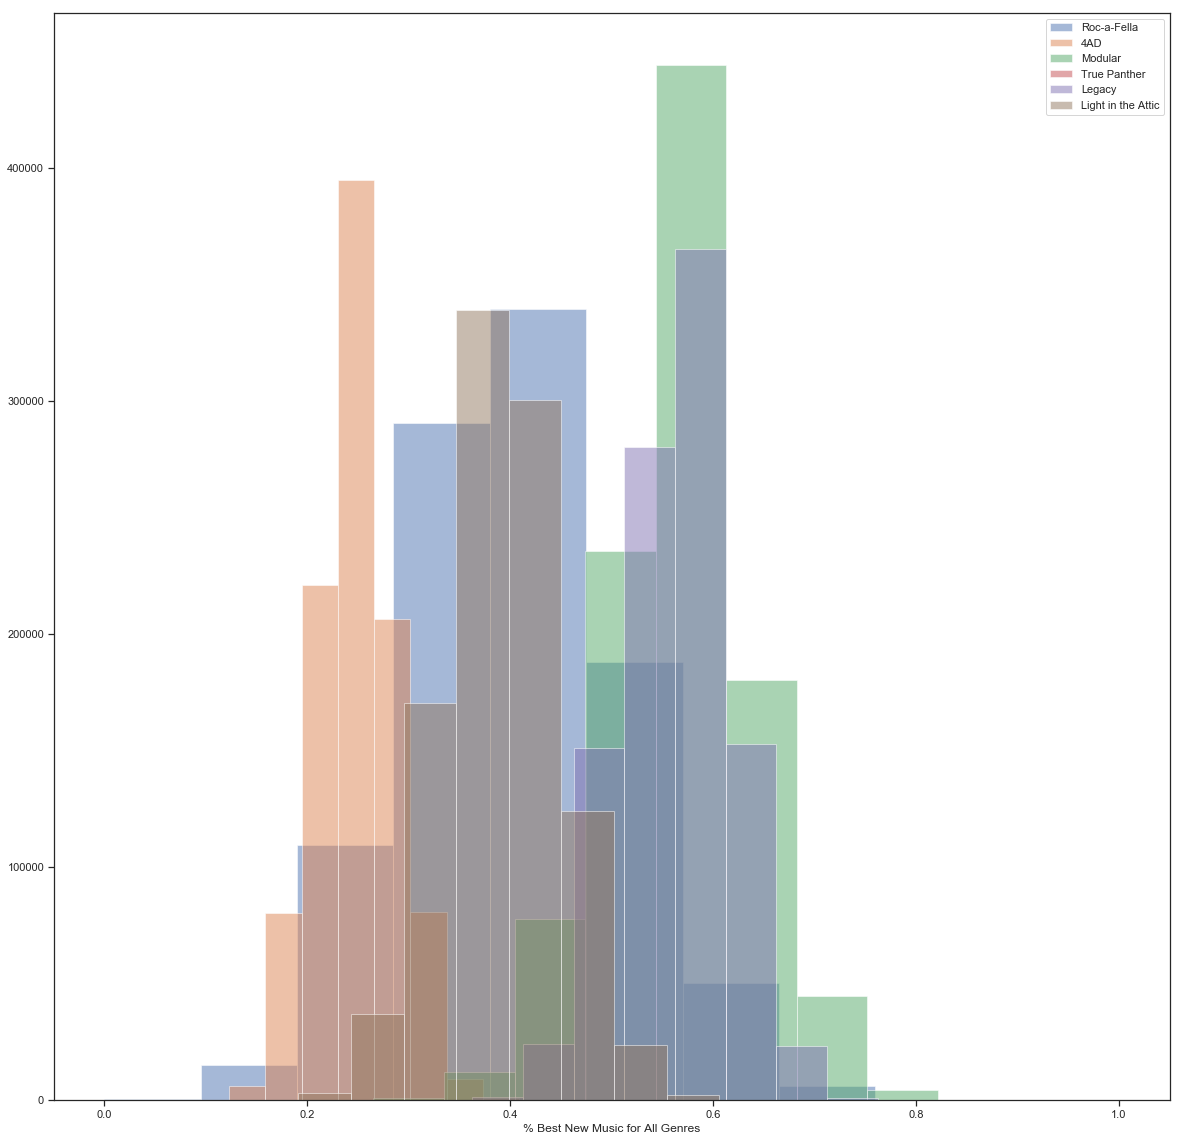

In [70]:
fig, ax = plt.subplots(figsize=(20,20))
ax.hist(roc_a_fella_dist, alpha=.5, label='Roc-a-Fella')
ax.hist(four_ad_dist, alpha=.5, label='4AD')
ax.hist(modular_dist, alpha=.5, label = "Modular")
ax.hist(true_panther, alpha=.5, label = "True Panther")
ax.hist(legacy_dist, alpha=.5, label='Legacy')
ax.hist(light_attic_dist, alpha=.5, label='Light in the Attic')
ax.legend()
ax.set_xlabel("% Best New Music for All Genres");

We conduct one-tailed, above case, two-sample t-tests on the five labels with the highest percentage of best new music. All tests are held at the 0.05 alpha level. <br> <br>
Null Hypothesis: Roc-a-Fella has the same percentage of best new music awards as 4AD. <br>
Alternative Hypothesis: Roc-a-Fella has a greater percentage of best new music awards to 4AD.

In [161]:
p_roc_4ad = 1 - ((roc_a_fella_dist > four_ad_dist).sum() / 10**6)
p_roc_4ad

0.09209199999999995

Fail to reject the null hypothesis.

Null Hypothesis: 4AD has the same percentage of best new music awards as Modular. <br>
Alternative Hypothesis: 4AD has a greater percentage of best new music awards than Modular.

In [162]:
p_4ad_mod = 1 - ((four_ad_dist > modular_dist).sum()/10**6)
p_4ad_mod

0.999947

Fail to reject the null hypothesis. 

Null Hypothesis: Modular has the same percentage of best new music awards as True Panther. <br>
Alternative Hypothesis: Modular has a greater percentage of best new music awards than True Panther.

In [163]:
p_mod_true = 1 - ((modular_dist > true_panther_dist).sum()/10**6)
p_mod_true

0.49168599999999996

Fail to reject the null hypothesis.

Null Hypothesis: True Panther has the same percentage of best new music awards as Legacy. <br>
Alternative Hypothesis: True Panther has a greater percentage of best new music awards than Legacy.

In [164]:
p_true_leg = 1 - ((true_panther_dist > legacy_dist).sum()/10**6)
p_true_leg

0.493352

Fail to reject the null hypothesis.

Next, we conduct tests with the top labels that produce folk/country music.

Null Hypothesis: Legacy has the same percentage of best new music awards as Light in the Attic. <br>
Alternative Hypothesis: Legacy has a greater percentage of best new music awards than Light in the Attic.

In [165]:
p_leg_light = 1 - ((legacy_dist > light_attic_dist).sum()/10**6)
p_leg_light

0.011687000000000003

Reject the null hypothesis.

Null Hypothesis: 4AD has the same percentage of best new music awards as Legacy. <br>
Alternative Hypothesis: 4AD has a greater percentage of best new music awards than Legacy.

In [166]:
p_4ad_leg = 1 - ((four_ad_dist > legacy_dist).sum()/10**6)
p_4ad_leg

1.0

Fail to reject the null hypothesis.

Null Hypothesis: 4AD has the same percentage of best new music awards as Light in the Attic. <br>
Alternative Hypothesis: 4AD has a greater percentage of best new music awards than Light in the Attic.

In [167]:
p_4ad_light = 1 - ((four_ad_dist > light_attic_dist).sum()/10**6)
p_4ad_light

0.98573

Fail to reject the null hypothesis. <br><br>


Although Roc-a-Fella has the highest percentage of best new music awards, it is not significantly greater than 4AD at the 0.05 alpha level. Modular is not significantly greater than True Panther. True Panther is not signficantly greater than Legacy. Legacy is not significantly greater than Light in the Attic. 4AD is significantly greater than Legacy, Light in the Attic, and Modular. 

## Question 4: What authors that review folk/country music give, on average, higher scores than the average score? 

Select the number of reviews and average scores given by authors who review folk/country music and put into a dataframe.

In [78]:
query_authors = """ SELECT reviews.author
, COUNT(reviews.author)
, AVG(reviews.score)
FROM reviews
JOIN genres ON reviews.reviewid = genres.reviewid
WHERE author IN (SELECT author FROM reviews JOIN genres ON reviews.reviewid = genres.reviewid WHERE genre = 'folk/country')
GROUP BY
reviews.author
ORDER BY
COUNT(reviews.author) DESC
;"""

In [79]:
authors_df = pd.read_sql(query_authors, conn)

In [80]:
authors_df.head()

,author,count,avg
0,joe tangari,987,7.378723
1,ian cohen,855,6.250994
2,stephen m. deusner,779,6.966496
3,brian howe,651,7.063902
4,mark richardson,614,7.533876


In [81]:
authors_df.shape

(130, 3)

In [82]:
authors_df.describe()

,count,avg
count,130.000000,130.000000
mean,140.269231,6.951526
std,179.195653,0.462801
min,1.000000,5.600000
25%,25.000000,6.659524
50%,62.000000,6.961220
75%,186.500000,7.264480
max,987.000000,8.318182


Visualize distributions of count, average score, and relationship between average score and count.

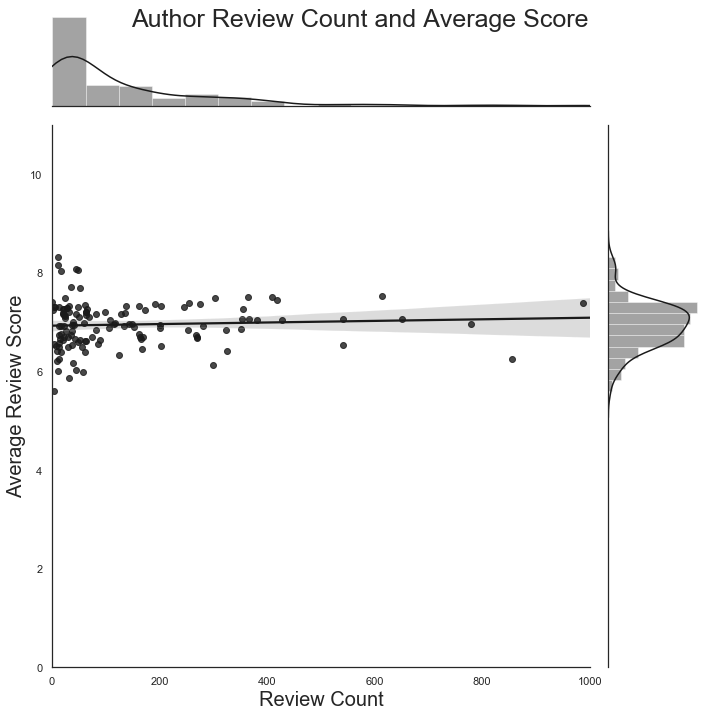

In [83]:
sns.set()
sns.set_style("white")
sns.jointplot(authors_df['count'], authors_df['avg'], height=10, kind='reg', color='k')
plt.xlabel('Review Count', fontsize='20')
plt.ylabel('Average Review Score', fontsize='20')
plt.suptitle('Author Review Count and Average Score', fontsize='25')
plt.xlim(0, 1000)
plt.ylim(0, 11);

There are 130 authors that have reviewed country/folk music, however, only an average of 140 reviews per author, and most authors between 25 and 187 reviews. With so many authors, can't do a one-way variance test because one or more with be different just due to chance and the power will not be high enough to detect even a larger effect size without large sample sizes (at least bigger than 130 from general rule of thumb). Instead of comparing for variance across all authors, decide to identify upper range outliers (above 75 percentile) and test against average score for significance.

In [84]:
outlier_df = authors_df[authors_df['avg'] > 7.264480].copy().reset_index().drop('index', axis=1)

In [85]:
outlier_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 3 columns):
author    33 non-null object
count     33 non-null int64
avg       33 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 872.0+ bytes


There are 33 authors with an average review score above the 75th percentile. Narrow down further by conducting a power analysis to estimate minimum sample size (number of reviews) for one sample t-test.

In [86]:
def p_analysis_one_sample(effect, alpha, power):
    """Return minimum sample size for one sample or same sized samples.""" 
    result = TTestIndPower().solve_power(effect, power=power, nobs1=None, alpha=alpha)
    print(f"Minimum Sample Size: {result}")

In [87]:
p_analysis_one_sample(0.8, 0.05, 0.8)

Minimum Sample Size: 25.52457250047935


Limit to authors with at least 26 reviews and select authors with top 5 average review scores.

In [88]:
outlier_26 = outlier_df[outlier_df['count'] > 26].copy()

In [89]:
sorted_outlier_26 = outlier_26.sort_values('avg', ascending=False).reset_index().drop('index', axis=1).copy()

In [90]:
outliers = sorted_outlier_26['author'].values.tolist()

In [91]:
len(outliers)

23

In [92]:
top_5 = sorted_outlier_26[:5]['author'].values.tolist()

Query for all author score reviews and visualize to look at normality.

In [93]:
query_author_scores = """ SELECT author
, score
FROM reviews
;"""

In [94]:
author_scores_df = pd.read_sql(query_author_scores, conn)

In [95]:
df_top1 = author_scores_df[author_scores_df['author'] == top_5[0]].copy()
df_top2 = author_scores_df[author_scores_df['author'] == top_5[1]].copy()
df_top3 = author_scores_df[author_scores_df['author'] == top_5[2]].copy()
df_top4 = author_scores_df[author_scores_df['author'] == top_5[3]].copy()
df_top5 = author_scores_df[author_scores_df['author'] == top_5[4]].copy()

Bootstrap all samples.

In [96]:
top1_stats = bootstrap(df_top1['score'])
top2_stats = bootstrap(df_top1['score'])
top3_stats = bootstrap(df_top1['score'])
top4_stats = bootstrap(df_top1['score'])
top5_stats = bootstrap(df_top1['score'])
author_scores_stats = bootstrap(author_scores_df['score'])

In [97]:
pop_mean = author_scores_stats.mean()

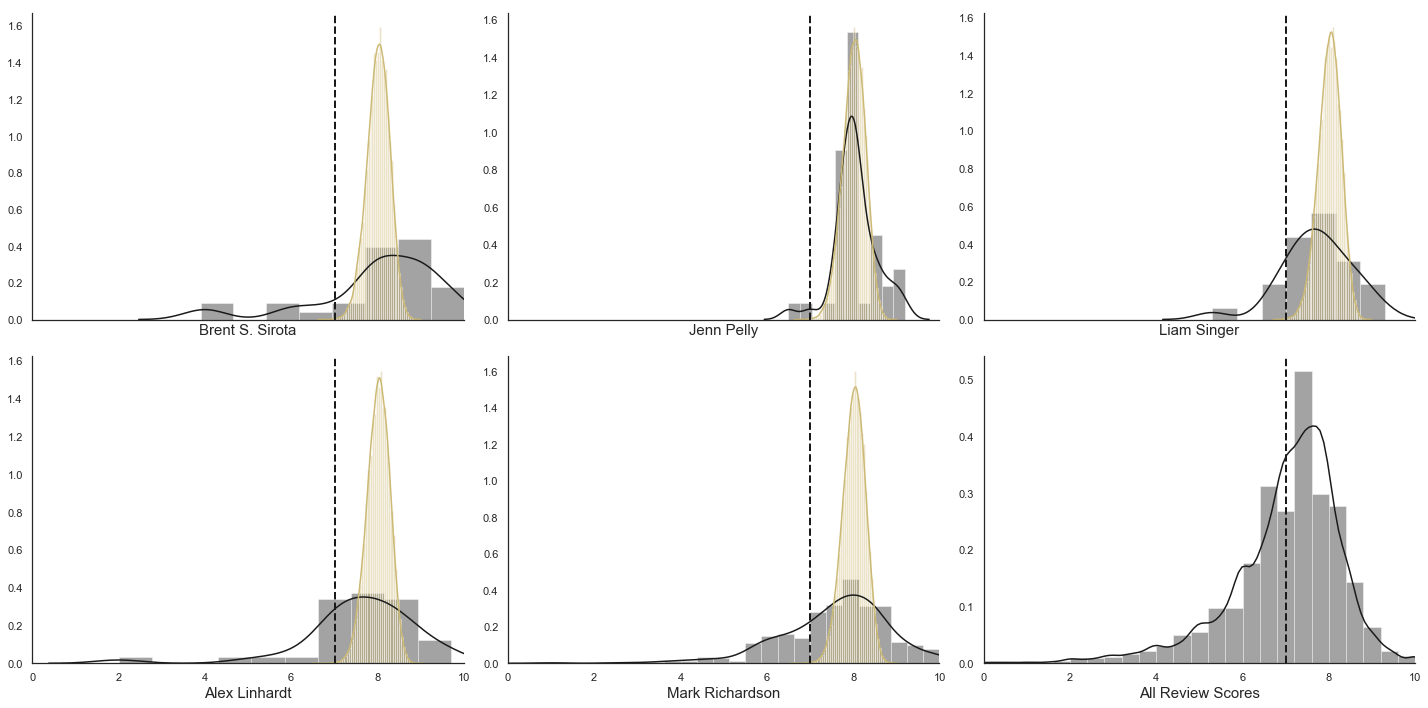

In [98]:
sns.set()
sns.set_style("white")
fig, axes = plt.subplots(2, 3, figsize=(20, 10), sharex=True)
plt.xlim(0, 10)
# plt.suptitle('Score Distributions for Top 5 Authors with Highest Average Scores and All Scores', fontsize='25')

ax1 = sns.distplot(df_top1['score'], color='k', ax=axes[0, 0])
ax2 = sns.distplot(df_top2['score'], color='k', ax=axes[0, 1])
ax3 = sns.distplot(df_top3['score'], color='k', ax=axes[0, 2])
ax4 = sns.distplot(df_top4['score'], color='k', ax=axes[1, 0])
ax5 = sns.distplot(df_top5['score'], color='k', ax=axes[1, 1])
ax6 = sns.distplot(author_scores_df['score'], color='k', bins=25, label='author scores', ax=axes[1, 2])

# Add bootstrapped visual for all but all scores (no need, is population andu just creates straight line)
ax7 = sns.distplot(top1_stats, color='y', ax=axes[0, 0])
ax8 = sns.distplot(top2_stats, color='y', ax=axes[0, 1])
ax9 = sns.distplot(top3_stats, color='y', ax=axes[0, 2])
ax10 = sns.distplot(top4_stats, color='y', ax=axes[1, 0])
ax11 = sns.distplot(top5_stats, color='y', ax=axes[1, 1])

# Add estimated population mean line
ax1.axvline(x=pop_mean, color='k', linestyle='--', linewidth=2)
ax2.axvline(x=pop_mean, color='k', linestyle='--', linewidth=2)
ax3.axvline(x=pop_mean, color='k', linestyle='--', linewidth=2)
ax4.axvline(x=pop_mean, color='k', linestyle='--', linewidth=2)
ax5.axvline(x=pop_mean, color='k', linestyle='--', linewidth=2)
ax6.axvline(x=pop_mean, color='k', linestyle='--', linewidth=2)


# Title all plots
ax1.set_xlabel(top_5[0].title(), fontsize='15')
ax2.set_xlabel(top_5[1].title(), fontsize='15')
ax3.set_xlabel(top_5[2].title(), fontsize='15')
ax4.set_xlabel(top_5[3].title(), fontsize='15')
ax5.set_xlabel(top_5[4].title(), fontsize='15')
ax6.set_xlabel('All Review Scores', fontsize='15')
sns.despine()
plt.tight_layout()
plt.show();

Conduct a one-tailed, one sample t-test for the authors with highest average review scores against the boostrapped average score. 

In [99]:
def above_case_one_sample_ttest(data, pop_mean, alpha):
    """Returns result from above case one sample t-test."""
    results = ttest_1samp(data, pop_mean)
    if (results[0] > 0) & (results[1]/2 < alpha):
        print(f"Reject the null hypothesis, {round(data.mean(), 2)} is greater than {round(pop_mean, 2)} with p-value = {round(results[1]/2, 3)}.")
    else:
        print("Accept the null hypothesis.")

In [100]:
above_case_one_sample_ttest(df_top1['score'], pop_mean, 0.05)

Reject the null hypothesis, 8.02 is greater than 7.01 with p-value = 0.0.


In [101]:
for author in outliers:
    author_df = author_scores_df[author_scores_df['author'] == author].copy()
    print(author.title())
    above_case_one_sample_ttest(bootstrap(author_df['score']), pop_mean, 0.5)

Brent S. Sirota
Reject the null hypothesis, 8.02 is greater than 7.01 with p-value = 0.0.
Jenn Pelly
Reject the null hypothesis, 8.06 is greater than 7.01 with p-value = 0.0.
Liam Singer
Reject the null hypothesis, 7.72 is greater than 7.01 with p-value = 0.0.
Alex Linhardt
Reject the null hypothesis, 7.62 is greater than 7.01 with p-value = 0.0.
Mark Richardson
Reject the null hypothesis, 7.58 is greater than 7.01 with p-value = 0.0.
Dominique Leone
Reject the null hypothesis, 7.5 is greater than 7.01 with p-value = 0.0.
Brandon Stosuy
Reject the null hypothesis, 7.49 is greater than 7.01 with p-value = 0.0.
Andy Beta
Reject the null hypothesis, 7.47 is greater than 7.01 with p-value = 0.0.
Marc Masters
Reject the null hypothesis, 7.47 is greater than 7.01 with p-value = 0.0.
Matt Lemay
Reject the null hypothesis, 7.31 is greater than 7.01 with p-value = 0.0.
Joe Tangari
Reject the null hypothesis, 7.38 is greater than 7.01 with p-value = 0.0.
Chris Dahlen
Reject the null hypothesis, 

For all of the authors who have written more than 25 reviews and have average review scores above the 75th percentile, their average review score is significantly greater than the average review score at the 0.05 alpha level.

## Question 5: What labels of folk/country music have, on average, review scores greater than the average review score?

In [102]:
query_labels = """ SELECT labels.label
, COUNT(reviews.score)
, AVG(reviews.score)
FROM labels
JOIN reviews ON labels.reviewid = reviews.reviewid
WHERE label IN (SELECT labels.label FROM labels JOIN genres ON labels.reviewid = genres.reviewid WHERE genre = 'folk/country')
GROUP BY
labels.label
ORDER BY
COUNT(reviews.score) DESC
;"""

In [103]:
labels_df = pd.read_sql(query_labels, conn)

In [104]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337 entries, 0 to 336
Data columns (total 3 columns):
label    337 non-null object
count    337 non-null int64
avg      337 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 8.0+ KB


In [105]:
labels_df.head()

,label,count,avg
0,self-released,420,6.917619
1,drag city,272,7.170221
2,sub pop,268,7.116791
3,thrill jockey,244,7.061885
4,merge,239,7.291213


In [106]:
labels_df.describe()

,count,avg
count,337.000000,337.000000
mean,26.035608,7.067553
std,49.529860,0.721597
min,1.000000,3.000000
25%,1.000000,6.780769
50%,7.000000,7.119048
75%,26.000000,7.500000
max,420.000000,8.966667


Visualize relationship.

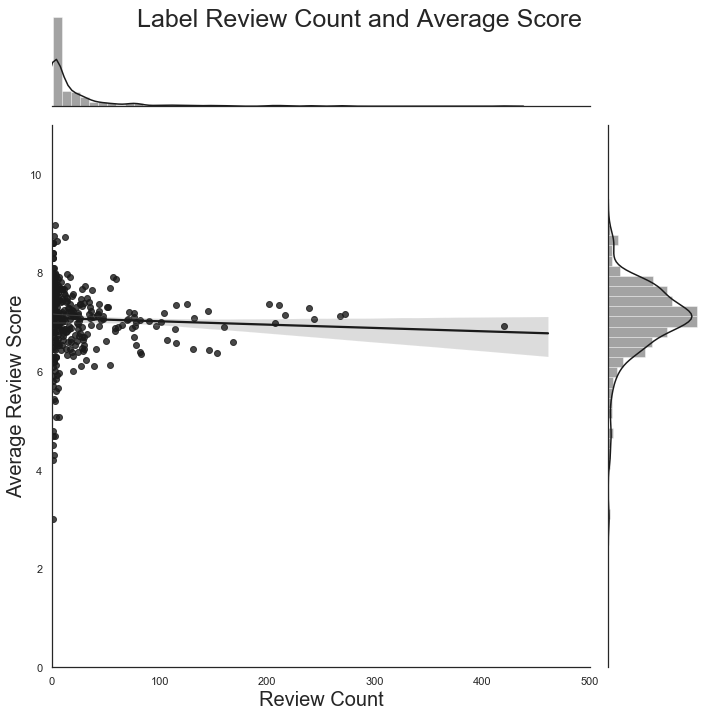

In [107]:
sns.set()
sns.set_style("white")
sns.jointplot(labels_df['count'], labels_df['avg'], height=10, kind='reg', color='k')
plt.xlabel('Review Count', fontsize='20')
plt.ylabel('Average Review Score', fontsize='20')
plt.suptitle('Label Review Count and Average Score', fontsize='25')
plt.xlim(0, 500)
plt.ylim(0, 11);

There are 337 labels representing at least one folk/country artist. Some artists may be signed under multiple labels, meaning the review scores could be shared between and the data may not be independent. Labels that represent folk/country have an average of 32 reviews, and most are between 2 and 33 reviews. With so many different labels, also decide to limit to labels with over 26 reviews to achieve power of detecting large effects (0.8 size) 80% of the time at an 0.05 alpha level, and average review scores above the 75% percentile.

In [108]:
label_outliers = labels_df[(labels_df['count'] > 26) & (labels_df['avg'] > 7.5)].copy()

In [109]:
label_outliers

,label,count,avg
40,numero group,60,7.878333
43,light in the attic,57,7.907018
45,legacy,54,7.683333
60,rvng intl.,37,7.651351
70,young god,31,7.735484
81,tompkins square,28,7.664286


In [110]:
label_outliers_list = label_outliers['label'].tolist()
label_outliers_list

['numero group',
 'light in the attic',
 'legacy',
 'rvng intl.',
 'young god',
 'tompkins square']

Already know that all review scores approximate a normal distribution. Query for all scores for each outlier label to visualize distributions.

In [111]:
outlier1_df = pd.read_sql("""SELECT reviews.score
FROM reviews
JOIN labels on reviews.reviewid = labels.reviewid
WHERE labels.label = 'numero group'
;""", conn)

In [112]:
outlier1_df['score'].head()

0    8.4
1    7.3
2    8.1
3    6.2
4    8.8
Name: score, dtype: float64

In [113]:
outlier2_df = pd.read_sql("""SELECT reviews.score
FROM reviews
JOIN labels on reviews.reviewid = labels.reviewid
WHERE labels.label = 'light in the attic'
;""", conn)

In [114]:
outlier3_df = pd.read_sql("""SELECT reviews.score
FROM reviews
JOIN labels on reviews.reviewid = labels.reviewid
WHERE labels.label = 'legacy'
;""", conn)

In [115]:
outlier4_df = pd.read_sql("""SELECT reviews.score
FROM reviews
JOIN labels on reviews.reviewid = labels.reviewid
WHERE labels.label = 'rvng intl.'
;""", conn)

In [116]:
outlier5_df = pd.read_sql("""SELECT reviews.score
FROM reviews
JOIN labels on reviews.reviewid = labels.reviewid
WHERE labels.label = 'leaf'
;""", conn)

In [117]:
outlier6_df = pd.read_sql("""SELECT reviews.score
FROM reviews
JOIN labels on reviews.reviewid = labels.reviewid
WHERE labels.label = 'young god'
;""", conn)

In [118]:
outlier7_df = pd.read_sql("""SELECT reviews.score
FROM reviews
JOIN labels on reviews.reviewid = labels.reviewid
WHERE labels.label = 'tompkins square'
;""", conn)

In [119]:
outlier8_df = pd.read_sql("""SELECT reviews.score
FROM reviews
JOIN labels on reviews.reviewid = labels.reviewid
WHERE labels.label = 'three lobed'
;""", conn)

Bootstrap outliers

In [120]:
b1_stats = bootstrap(outlier1_df['score'])
b2_stats = bootstrap(outlier2_df['score'])
b3_stats = bootstrap(outlier3_df['score'])
b4_stats = bootstrap(outlier4_df['score'])
b5_stats = bootstrap(outlier5_df['score'])
b6_stats = bootstrap(outlier6_df['score'])
b7_stats = bootstrap(outlier7_df['score'])
b8_stats = bootstrap(outlier8_df['score'])


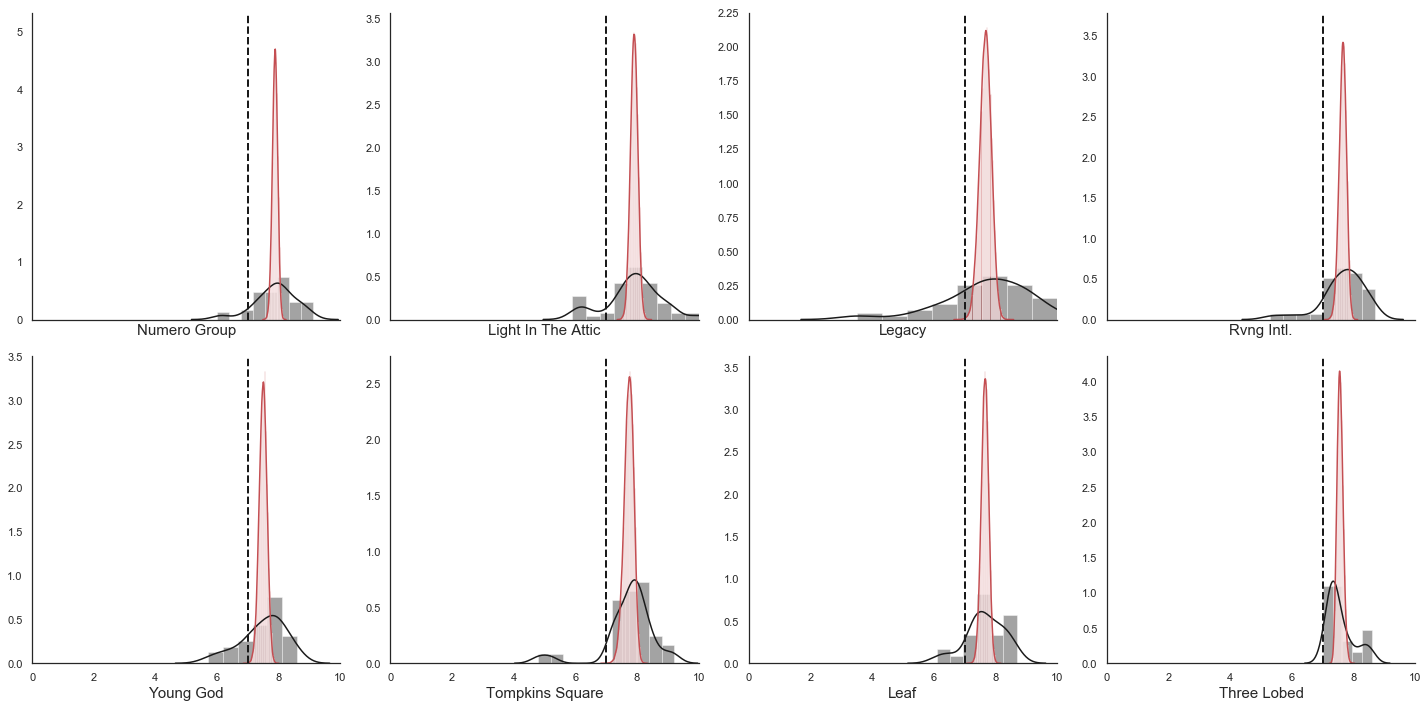

In [121]:
sns.set()
sns.set_style("white")
fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharex=True)
plt.xlim(0, 10)
# plt.suptitle('Score Distributions for Labels with Highest Average Scores', fontsize='25')
ax1 = sns.distplot(outlier1_df, color='k', ax=axes[0, 0])
ax2 = sns.distplot(outlier2_df, color='k', ax=axes[0, 1])
ax3 = sns.distplot(outlier3_df, color='k', ax=axes[0, 2])
ax4 = sns.distplot(outlier4_df, color='k', ax=axes[0, 3])
ax5 = sns.distplot(outlier5_df, color='k', ax=axes[1, 0])
ax6 = sns.distplot(outlier6_df, color='k', ax=axes[1, 1])
ax7 = sns.distplot(outlier7_df, color='k', ax=axes[1, 2])
ax8 = sns.distplot(outlier8_df, color='k', ax=axes[1, 3])

# Add bootstrapped visual for all but all scores (no need, is population andu just creates straight line)
ax9 = sns.distplot(b1_stats, color='r', ax=axes[0, 0])
ax10 = sns.distplot(b2_stats, color='r', ax=axes[0, 1])
ax11 = sns.distplot(b3_stats, color='r', ax=axes[0, 2])
ax12 = sns.distplot(b4_stats, color='r', ax=axes[0, 3])
ax13 = sns.distplot(b5_stats, color='r', ax=axes[1, 0])
ax14 = sns.distplot(b6_stats, color='r', ax=axes[1, 1])
ax15 = sns.distplot(b7_stats, color='r', ax=axes[1, 2])
ax16 = sns.distplot(b8_stats, color='r', ax=axes[1, 3])

# Add estimated population mean line
ax1.axvline(x=pop_mean, color='k', linestyle='--', linewidth=2)
ax2.axvline(x=pop_mean, color='k', linestyle='--', linewidth=2)
ax3.axvline(x=pop_mean, color='k', linestyle='--', linewidth=2)
ax4.axvline(x=pop_mean, color='k', linestyle='--', linewidth=2)
ax5.axvline(x=pop_mean, color='k', linestyle='--', linewidth=2)
ax6.axvline(x=pop_mean, color='k', linestyle='--', linewidth=2)
ax7.axvline(x=pop_mean, color='k', linestyle='--', linewidth=2)
ax8.axvline(x=pop_mean, color='k', linestyle='--', linewidth=2)

# Add labels for each plot
ax1.set_xlabel(label_outliers_list[0].title(), fontsize='15')
ax2.set_xlabel(label_outliers_list[1].title(), fontsize='15')
ax3.set_xlabel(label_outliers_list[2].title(), fontsize='15')
ax4.set_xlabel(label_outliers_list[3].title(), fontsize='15')
ax5.set_xlabel(label_outliers_list[4].title(), fontsize='15')
ax6.set_xlabel(label_outliers_list[5].title(), fontsize='15')
ax7.set_xlabel("Leaf", fontsize='15')
ax8.set_xlabel("Three Lobed", fontsize='15')
sns.despine()
plt.tight_layout()
plt.show();

Conduct a one-tailed one sample t-test for labels with highest average review score.

In [122]:
pop_mean = author_scores_stats.mean() # mean of all bootstrapped review scores

def above_case_one_sample_ttest(data, pop_mean, alpha):
    """Returns result from above case one sample t-test."""
    results = ttest_1samp(data, pop_mean)
    if (results[0] > 0) & (results[1]/2 < alpha):
        print(f"Reject the null hypothesis, {round(data.mean(), 2)} is greater than {round(pop_mean, 2)} with a p-value = {results[1]/2}.")
    else:
        print("Accept the null hypothesis.")

In [123]:
print(f"{label_outliers_list[0].title()}")
above_case_one_sample_ttest(b1_stats, pop_mean, 0.05)
print(f"{label_outliers_list[1].title()}")
above_case_one_sample_ttest(b2_stats, pop_mean, 0.05)
print(f"{label_outliers_list[2].title()}")
above_case_one_sample_ttest(b3_stats, pop_mean, 0.05)
print(f"{label_outliers_list[3].title()}")
above_case_one_sample_ttest(b4_stats, pop_mean, 0.05)
print(f"{label_outliers_list[4].title()}")
above_case_one_sample_ttest(b5_stats, pop_mean, 0.05)
print(f"{label_outliers_list[5].title()}")
above_case_one_sample_ttest(b6_stats, pop_mean, 0.05)
print(f"{label_outliers_list[6].title()}")
above_case_one_sample_ttest(b7_stats, pop_mean, 0.05)
print(f"{label_outliers_list[7].title()}")
above_case_one_sample_ttest(b8_stats, pop_mean, 0.05)

Numero Group
Reject the null hypothesis, 7.88 is greater than 7.01 with a p-value = 0.0.
Light In The Attic
Reject the null hypothesis, 7.91 is greater than 7.01 with a p-value = 0.0.
Legacy
Reject the null hypothesis, 7.68 is greater than 7.01 with a p-value = 0.0.
Rvng Intl.
Reject the null hypothesis, 7.65 is greater than 7.01 with a p-value = 0.0.
Young God
Reject the null hypothesis, 7.49 is greater than 7.01 with a p-value = 0.0.
Tompkins Square
Reject the null hypothesis, 7.73 is greater than 7.01 with a p-value = 0.0.


IndexError: list index out of range